# Merging Datasets with Baltimore City Open Data

In Excel, we used the `VLOOKUP` function to combine data in different workbooks or sheets based on shared ID column data in neighboring rows. To do this, we wrote the function: 
```
=VLOOKUP(cell in old dataset that matches a value in the first column of new dataset, 
        selected data table of new dataset, 
        row number of new data to add to old dataset, 
        exact match (0) OR approximate match (1))
```
which allowed us to add a column of data from *new dataset* to *old dataset* based on some shared/linking data. 

This is super helpful and time efficient if we want to combine or condense information from different data sources our outputs, however, we're limited in the number of data columns we can transfer at a time (one) and how our final dataset appears (for example, if we want to only keep data that's in both sheets, we need to add an extra step of filtering out the null cells in the post-VLOOKUP spreadsheet. We can use **pandas merge** function to combine larger datasets in a similar way in Python, but with broader functionality.

## [Pandas Merge](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.merge.html) 

Pandas merge allows us to merge two pandas dataframes together using the following convention: 

```
merged_df = pd.merge(left_df, 
                    right_df, 
                    how='inner', 
                    on=None, 
                    left_on=None, 
                    right_on=None, 
                    left_index=False, 
                    right_index=False, 
                    sort=False, 
                    suffixes=('_x', '_y'), 
                    copy=True, 
                    indicator=False, 
                    validate=None)
```
where we'll mostly need to be concerned with: 

 - __merged_df__ is the newly defined dataframe from the merged data
 - __pd__ is because we're using a pandas function
 - __merge__ is the pandas function that we're using to merge the dataframes
 - __left_df__ is the name of the dataframe that's our designated "left" dataframe
 - __right_df__ is the name of the dataframe that's our designated "right" dataframee
 - __how__ tells our dataframe how we want to merge the data (more details below)
 - __left_on__ is the name of the column that contains our "matching data" in the left dataframe
 - __right_on__ is the name of the column that contains our "matching data" in the right dataframe
 - __on__ is what we can use to define the column that contains our "matching data" is the column name is the same in both dataframes

The rest of these values are the default merge functions (defined [here](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.merge.html)), most of which we won't often need to tweak.

### Dataframes to Merge

In Excel, we can only transer data from one dataset to another, but in Python, we can merge all of the information from both datasets together, if we want. To merge our data, we'll identify the left and right data frame based on what data we want to merge onto existing data. 

For example, if we want to only merge a few columns from dataset df_A onto dataset df_B, we'll want to define df_B as the left dataframe and df_A as the right dataframe because we want to keep all of the data from df_B and add on some columns from df_A. However, we we want to merge all of the columns from df_A and df_B, then it doesn't really matter which dataframe we define as the left and right dataframe.

### Types of Merging 

Unlike in Excel, we can merge our data in in many different variations through the merge parameter in the merge function depending on how we define our right and left dataframes. In general, we can merge our left and right dataframes in the following ways:
 - __"left"__ merges data from the right dataframe onto the left dataframe *only if* if has a key that matches values in the left dataframe and fills in "NaN" (null) values in rows that don't have a value in the key column from the right dataframe
 - __"right"__ merges data from the left dataframe onto the right dataframe *only if* if has a key that matches values in the right dataframe and fills in "NaN" (null) values in rows that don't have a value in the key column from the left dataframe
 - __"outer"__ merges together and all of the data in both dataframes on the key column and fills in an "NaN" value for the columns and rows that don't have values or matches in the key column
 - __"inner"__ merges together only data that's in *both* dataframes
 
To get a better idea of what this means, we'll run through some examples of dataframe mergine with [Baltimore City 911 Call data](https://data.baltimorecity.gov/Public-Safety/911-Police-Calls-for-Service/xviu-ezkt), [Baltimore Victim Crime Data](https://data.baltimorecity.gov/Public-Safety/BPD-Part-1-Victim-Based-Crime-Data/wsfq-mvij), and [Baltimore City Police Department Arrest Data](https://data.baltimorecity.gov/Public-Safety/BPD-Arrests/3i3v-ibrt).

## import packages 

In [120]:
# import packages for data analysis and visualization
import pandas as pd
import plotly.express as px

## import data 

In [121]:
# import bpd arrest data
df_arrest = pd.read_csv("BPD_Arrests.csv")

In [122]:
# preview arrest data
df_arrest.head()

,Arrest,Age,Sex,Race,ArrestDate,ArrestTime,ArrestLocation,IncidentOffense,IncidentLocation,Charge,ChargeDescription,District,Post,Neighborhood,Longitude,Latitude,Location 1,2010 Census Neighborhoods,2010 Census Wards Precincts,Zip Codes
0,14215855.0,37.0,M,W,12/31/2014,04:00,NaN,Unknown Offense,NaN,NaN,FUGITIVE FROM COLORADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,24.0,M,B,12/30/2015,14:30,NaN,Unknown Offense,NaN,NaN,Unknown Charge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,41.0,M,B,12/14/2019,16:35,NaN,Unknown Offense,NaN,NaN,Unknown Charge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,46.0,M,W,12/11/2019,15:45,NaN,Unknown Offense,NaN,NaN,Unknown Charge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19174456.0,39.0,F,B,12/10/2019,10:48,NaN,Unknown Offense,NaN,NaN,DETAIN ONLY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
# import baltimore city 911 call data
df_911 = pd.read_csv("911_Police_Calls_for_Service.csv", low_memory = False)

In [128]:
# preview 911 data:
df_911.head()

,RecordID,CallNumber,CallDateTime,Priority,District,Description,IncidentLocation,ZipCode,Neighborhood,PoliceDistrict,PolicePost,CouncilDistrict,SheriffDistricts,Community_Statistical_Areas,Census_Tracts,VRIZones,Location,2010 Census Neighborhoods,2010 Census Wards Precincts,Zip Codes
0,2333660,P163072128,11/02/2016 04:46:00 PM,Medium,SD,NARCOTICSOutside,1200 W CROSS ST,21230.0,Washington Village/Pigtown,Southern,932.0,10.0,D7,Washington Village/Pigtown,Census Tract 2102,NaN,"1200 W CROSS ST\nBALTIMORE, MD\n(39.281995, -7...",250.0,177.0,27953.0
1,2334887,P163070732,11/02/2016 09:22:00 AM,High,SW,Traffic Stop,2100 W PRATT ST,21223.0,Carrollton Ridge,Southwestern,841.0,9.0,D8,Southwest Baltimore,Census Tract 2005,Tri-District,"2100 W PRATT ST\nBALTIMORE, MD\n(39.284965, -7...",36.0,279.0,27632.0
2,2334245,P163071480,11/02/2016 01:37:00 PM,Low,SE,LARCENY F/AUTO,HOME DEPOT,21224.0,Pulaski Industrial Area,Southeastern,242.0,1.0,D6,Orangeville/East Highlandtown,Census Tract 2605.01,NaN,"HOME DEPOT BALTIMORE, MD\n(39.499699, -76.641403)",NaN,NaN,3490.0
3,2332907,P163072974,11/02/2016 08:20:00 PM,Medium,ND,911/NO VOICE,5200 YORK RD,21212.0,York-Homeland,Northern,521.0,4.0,D2,North Baltimore/Guilford/Homeland,Census Tract 2711.01,NaN,"5200 YORK RD\nBALTIMORE, MD\n(39.352315, -76.6...",273.0,217.0,14009.0
4,2332699,P163073203,11/02/2016 09:39:00 PM,Medium,NW,COMMON ASSAULT,2500 N ELLAMONT ST,21216.0,Hanlon-Longwood,Northwestern,641.0,7.0,D9,Greater Mondawmin,Census Tract 1507.01,NaN,"2500 N ELLAMONT ST\nBALTIMORE, MD\n(39.315441,...",103.0,46.0,27297.0


In [125]:
# import victim crime data
df_crime = pd.read_csv("BPD_Part_1_Victim_Based_Crime_Data.csv")

/Users/melanieshimano/opt/anaconda3/envs/decision-analytics/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



In [126]:
# preview crime data
df_crime.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
0,02/29/2020,20:45:00,6D,MONROE ST & W PRATT ST,LARCENY FROM AUTO,NaN,NaN,934,SOUTHERN,NaN,-76.646758,39.285162,NaN,NaN,Tri-District,1
1,02/29/2020,22:00:00,6G,4200 ERDMAN AVE,LARCENY,I,NaN,434,NORTHEAST,ORANGEVILLE INDUSTRIAL AREA,-76.567706,39.313407,NaN,RETAIL/SMALL BUSINES,NaN,1
2,02/29/2020,18:55:00,3AJF,1700 WASHINGTON BLVD,ROBBERY - CARJACKING,O,FIREARM,935,SOUTHERN,CARROLL - CAMDEN INDUSTRIAL AREA,-76.641304,39.275903,NaN,BUS. PARK LOT-OUTSID,NaN,1
3,02/29/2020,21:27:00,7A,DUKELAND ST & GWYNNS FALLS PY,AUTO THEFT,O,NaN,611,NORTHWEST,NaN,-76.664448,39.314691,NaN,OTHER - OUTSIDE,NaN,1
4,02/29/2020,10:26:00,4E,1000 APPLETON ST,COMMON ASSAULT,I,NaN,722,WESTERN,MIDTOWN EDMONDSON,-76.648418,39.300291,NaN,ROW/TOWNHOUSE-OCC,NaN,1


In our datasets we have a lot of information about arrests, crime, and 911 calls in Baltimore. Let's say that we want to aggregate all of this to look at the number of 911 calls, arrests, and crimes happening every year. 

To do this, we'll first need to aggregate our dataframes to count the number of occurrances per year. 

## Data Cleaning 

In [129]:
# look at the data types for each of our datasets (911)
df_911.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7475140 entries, 0 to 7475139
Data columns (total 20 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   RecordID                     int64  
 1   CallNumber                   object 
 2   CallDateTime                 object 
 3   Priority                     object 
 4   District                     object 
 5   Description                  object 
 6   IncidentLocation             object 
 7   ZipCode                      float64
 8   Neighborhood                 object 
 9   PoliceDistrict               object 
 10  PolicePost                   float64
 11  CouncilDistrict              float64
 12  SheriffDistricts             object 
 13  Community_Statistical_Areas  object 
 14  Census_Tracts                object 
 15  VRIZones                     object 
 16  Location                     object 
 17  2010 Census Neighborhoods    float64
 18  2010 Census Wards Precincts  float64
 19  

In [137]:
# df_arrest info
df_arrest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155461 entries, 0 to 155460
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Arrest                       148070 non-null  float64       
 1   Age                          155419 non-null  float64       
 2   Sex                          155461 non-null  object        
 3   Race                         155461 non-null  object        
 4   ArrestDate                   155461 non-null  object        
 5   ArrestTime                   155461 non-null  object        
 6   ArrestLocation               82735 non-null   object        
 7   IncidentOffense              155461 non-null  object        
 8   IncidentLocation             82735 non-null   object        
 9   Charge                       137953 non-null  object        
 10  ChargeDescription            155461 non-null  object        
 11  District                  

In [138]:
# df crime info
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295151 entries, 0 to 295150
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   CrimeDate        295151 non-null  object        
 1   CrimeTime        295127 non-null  object        
 2   CrimeCode        295151 non-null  object        
 3   Location         293801 non-null  object        
 4   Description      295151 non-null  object        
 5   Inside/Outside   260796 non-null  object        
 6   Weapon           62114 non-null   object        
 7   Post             292750 non-null  object        
 8   District         295151 non-null  object        
 9   Neighborhood     284545 non-null  object        
 10  Longitude        293491 non-null  float64       
 11  Latitude         293491 non-null  float64       
 12  Location 1       0 non-null       float64       
 13  Premise          260544 non-null  object        
 14  vri_name1        348

### Convert columns to datetime datatype 

We see that none of our datasets have our date or time values as datasets, so we'll need to convert them to datetime formats similar to our work last week.

In [133]:
# create a new column in the arrest data with both of the date and time data
df_arrest["DateTime"] = df_arrest["ArrestDate"] + " " + df_arrest["ArrestTime"]

In [134]:
# convert arrest date time column to a datetime data type
df_arrest["DateTime"] = pd.to_datetime(df_arrest["DateTime"])

In [135]:
# create a new column in the crime dataset with both the date and time data
df_crime["DateTime"] = df_crime["CrimeDate"] + " " + df_crime["CrimeTime"]

In [136]:
# convert crime date time column into a datetime datatype
df_crime["DateTime"] = pd.to_datetime(df_crime["DateTime"])

We need to define the format of our datetime object in the 911 call data because we have an AM/PM string in the date time value. We also need to do this if our datetime string that we want to convert into a datetime object is in any format other than `month/date/year 24hour:min:second`

A full list of the formatting for datetime is listed [here](https://www.programiz.com/python-programming/datetime/strftime). Our 911 data's CallDateTime column lists values like `11/02/2016 04:46:00 PM`, so we'll need to define our datetime column with: 

 - __%m__ for month
 - __%d__ for day
 - __%Y__ for 4-digit year
 - __%I__ for 12-hour clock
 - __%M__ for minute
 - __%S__ for second
 - __%p__ for am/pm

In [139]:
# convert the 911 date time column into a datetime datatype (since the values are already together in one column)
df_911["DateTime"] = pd.to_datetime(df_911["CallDateTime"], format = "%m/%d/%Y %I:%M:%S %p")

In [140]:
df_911.head(3)

,RecordID,CallNumber,CallDateTime,Priority,District,Description,IncidentLocation,ZipCode,Neighborhood,PoliceDistrict,...,CouncilDistrict,SheriffDistricts,Community_Statistical_Areas,Census_Tracts,VRIZones,Location,2010 Census Neighborhoods,2010 Census Wards Precincts,Zip Codes,DateTime
0,2333660,P163072128,11/02/2016 04:46:00 PM,Medium,SD,NARCOTICSOutside,1200 W CROSS ST,21230.0,Washington Village/Pigtown,Southern,...,10.0,D7,Washington Village/Pigtown,Census Tract 2102,NaN,"1200 W CROSS ST\nBALTIMORE, MD\n(39.281995, -7...",250.0,177.0,27953.0,2016-11-02 16:46:00
1,2334887,P163070732,11/02/2016 09:22:00 AM,High,SW,Traffic Stop,2100 W PRATT ST,21223.0,Carrollton Ridge,Southwestern,...,9.0,D8,Southwest Baltimore,Census Tract 2005,Tri-District,"2100 W PRATT ST\nBALTIMORE, MD\n(39.284965, -7...",36.0,279.0,27632.0,2016-11-02 09:22:00
2,2334245,P163071480,11/02/2016 01:37:00 PM,Low,SE,LARCENY F/AUTO,HOME DEPOT,21224.0,Pulaski Industrial Area,Southeastern,...,1.0,D6,Orangeville/East Highlandtown,Census Tract 2605.01,NaN,"HOME DEPOT BALTIMORE, MD\n(39.499699, -76.641403)",NaN,NaN,3490.0,2016-11-02 13:37:00


Now if we look the `df.info()` all of the date time datatypes should be datetime datatypes.

#### Data Aggregation by Year

Now, let's aggregate the counts of each of our datatypes by the year by first creating a "year" column in each of our dataframes, then using the pandas groupby function to aggregate the counts of each dataset per year. 


We can either do this one at a time for each of our datasets similar to what we've done before, however, since we're using the dt.year function for all three datasets, we can take advantage of a python __for loop__ to do this with a little less code using the following convention: 
```
for __value__ in __range or list__:
    *do some action*
```
Which will allow us to perform the same action to whatever we've defined in the list. We want to add a "year" column to each of our dataframes by calling the same df.year function on the DateTime column, so we can make a list of the dataframes and tell our loop to create a new column based on the DateTime column for each dataframe. Note that this works since all of the date time columns are named the same "DateTime" name. If they weren't, we would need to rename the columns to make this for loop work.
  

In [141]:
# create list of dataframes
df_list = [df_911, df_arrest, df_crime]

We'll write: 

```
for df in df_list:
    df["year"] = df["DateTime"].dt.year
```

Where the __df__ is a placeholder that we've defined as a variable for the df in our repeating action. This can be anything as long as it's consistent and the same in the functions within the for loop. __df_list__ is the list we defined with all of our dataframes.

Essentially what we're saying is that for each value in our df_lists, plug in each list value any time you see a "df" and perform the function. 

In [142]:
# write a for loop to add a year column to the data
for df in df_list: 
    df["year"] = df["DateTime"].dt.year

In [144]:
# write a for loop to add a month column to the data
for df in df_list: 
    df["month"] = df["DateTime"].dt.month

In [145]:
# so if we preview the crime data now, we see the year column
df_crime.head(3)

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents,DateTime,year,month
0,02/29/2020,20:45:00,6D,MONROE ST & W PRATT ST,LARCENY FROM AUTO,NaN,NaN,934,SOUTHERN,NaN,-76.646758,39.285162,NaN,NaN,Tri-District,1,2020-02-29 20:45:00,2020.0,2.0
1,02/29/2020,22:00:00,6G,4200 ERDMAN AVE,LARCENY,I,NaN,434,NORTHEAST,ORANGEVILLE INDUSTRIAL AREA,-76.567706,39.313407,NaN,RETAIL/SMALL BUSINES,NaN,1,2020-02-29 22:00:00,2020.0,2.0
2,02/29/2020,18:55:00,3AJF,1700 WASHINGTON BLVD,ROBBERY - CARJACKING,O,FIREARM,935,SOUTHERN,CARROLL - CAMDEN INDUSTRIAL AREA,-76.641304,39.275903,NaN,BUS. PARK LOT-OUTSID,NaN,1,2020-02-29 18:55:00,2020.0,2.0


Now, we can aggregate the counts by year. We'll do this individually for this round since all of the columns that we want to count are named different things. 

Since we're combining all of this data at the end, we'll also want to rename our column data to specify which counts are in that column by defining the column name in the `.agg` function

In [154]:
# aggregate counts of 911 data
df_911_count = df_911.groupby("year")["CallDateTime"].agg(CallCount = "count").reset_index()

In [155]:
# preview data
df_911_count

,year,CallCount
0,2013,553998
1,2014,1073050
2,2015,1079493
3,2016,1052941
4,2017,1006292
5,2018,997079
6,2019,1442651
7,2020,269636


In [156]:
# aggregate counts of crime
df_crime_count = df_crime.groupby("year")["CrimeDate"].agg(CrimeCount = "count").reset_index()

In [157]:
# preview data
df_crime_count

,year,CrimeCount
0,1963.0,1
1,1969.0,1
2,1975.0,1
3,1977.0,1
4,1978.0,1
5,1980.0,1
6,1981.0,1
7,1982.0,1
8,1985.0,1
9,1988.0,1


In [158]:
# aggregate counts of arrests
df_arrest_count = df_arrest.groupby("year")["ArrestDate"].agg(ArrestCount = "count").reset_index()

In [159]:
# preview data
df_arrest_count

,year,ArrestCount
0,2014,38182
1,2015,26509
2,2016,23912
3,2017,23741
4,2018,21434
5,2019,19862
6,2020,1821


### Merging Data 

Now we can finally merge all of our data into one dataframe that merges the counts of crime, 911, and arrest data into one dataframe.

If we look at the length of each dataframe, we can see that some of the datasets have data for more years than other datasets: 

In [160]:
# length of crime year counts
len(df_crime_count)

33

In [161]:
# length of crime dataset
len(df_crime)

295151

In [105]:
# length of 911 call year counts


In [106]:
# length of arrest year counts


Since the crime count has the most years listed, we'll merge the arrest and crime counts onto the crime count dataframe with the `df.merge` function: 

In [167]:
# merge the 911 call counts onto the crime count dataframe
df_safety_merge = pd.merge(df_crime_count, df_arrest_count, on = "year", how = "left")

In [168]:
# preview tail data
df_safety_merge

,year,CrimeCount,ArrestCount
0,1963.0,1,NaN
1,1969.0,1,NaN
2,1975.0,1,NaN
3,1977.0,1,NaN
4,1978.0,1,NaN
5,1980.0,1,NaN
6,1981.0,1,NaN
7,1982.0,1,NaN
8,1985.0,1,NaN
9,1988.0,1,NaN


In [169]:
# merge the arrest count onto the merged df
df_safety_merge = pd.merge(df_safety_merge, df_911_count, on = "year", how = "left")

In [170]:
# final dataset
df_safety_merge

,year,CrimeCount,ArrestCount,CallCount
0,1963.0,1,NaN,NaN
1,1969.0,1,NaN,NaN
2,1975.0,1,NaN,NaN
3,1977.0,1,NaN,NaN
4,1978.0,1,NaN,NaN
5,1980.0,1,NaN,NaN
6,1981.0,1,NaN,NaN
7,1982.0,1,NaN,NaN
8,1985.0,1,NaN,NaN
9,1988.0,1,NaN,NaN


Since we only have useable data for 2014-2019, we'll filter our merged dataframe to only include those rows    

In [171]:
# filter dataframe based on values in the year column

df_safety_merge = df_safety_merge[(df_safety_merge["year"] >= 2014)  & (df_safety_merge["year"] <= 2019)]

In [172]:
#preview data
df_safety_merge

,year,CrimeCount,ArrestCount,CallCount
26,2014.0,45304,38182.0,1073050.0
27,2015.0,48186,26509.0,1079493.0
28,2016.0,48772,23912.0,1052941.0
29,2017.0,52162,23741.0,1006292.0
30,2018.0,48445,21434.0,997079.0
31,2019.0,46078,19862.0,1442651.0


Let's make a line plot to look at the changes of all of these over time. Since our data isn't formatted how we need it (all x values in one column and all y values in another column), we'll need to use the pandas `melt` function to rearrange our data in a format that works with plotly express.

In [173]:
# make a new "melted dataframe"
df_safety_melt = df_safety_merge.melt(id_vars = "year", value_vars =["CrimeCount", "ArrestCount", "CallCount"])

In [175]:
# preview melted dataframe
df_safety_melt.head()

,year,variable,value
0,2014.0,CrimeCount,45304.0
1,2015.0,CrimeCount,48186.0
2,2016.0,CrimeCount,48772.0
3,2017.0,CrimeCount,52162.0
4,2018.0,CrimeCount,48445.0


In [176]:
# now use this data to make aa line graph of changes over time
line_bmore_safety = px.line(df_safety_melt,
                           x = "year",
                           y ="value",
                           color = "variable",
                           title = "Count of Crime, Arrests, and 911 Calls in Baltimore from 2014-2019",
                           labels = {"year":"Year", "value":"Count"})

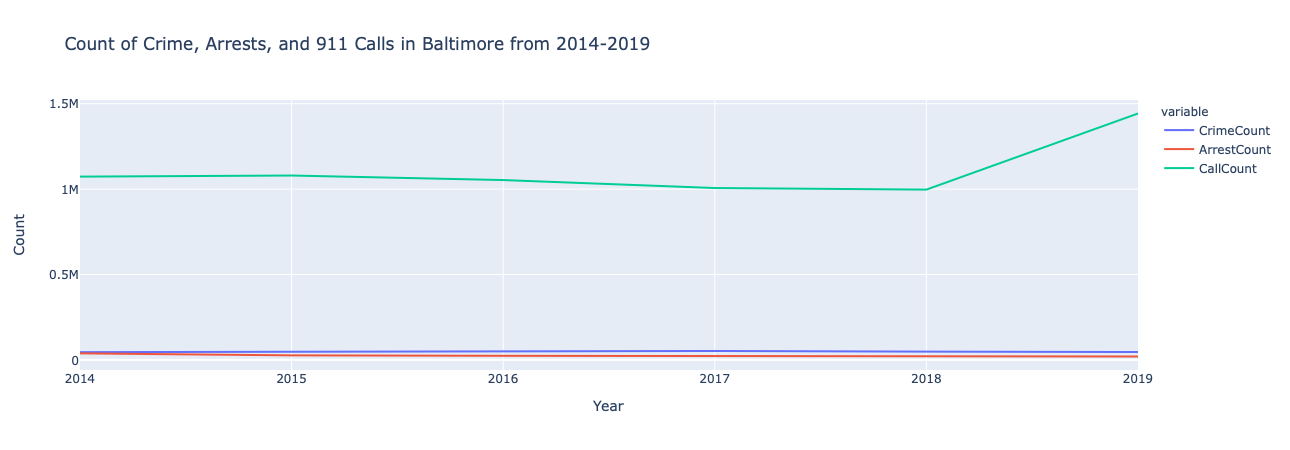

In [177]:
# view line graph
line_bmore_safety

## Exporting Data 

Here, we'll export our crime, 911 call, and arrest datasets since we've cleaned them a bit (to use in the future)

In [178]:
# export crime as a csv
df_crime_count.to_csv("in-class-export-crimedata.csv")

In [118]:
# export 911 call as a csv


In [119]:
# export arrest as a csv
